<a href="https://colab.research.google.com/github/srirakshareddy/Automated-Resume-Screening/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DISTIL BERT


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=0042ad7ce90fcc34feb711368cc7bfa473fb164ca94e5b7c4f8a34dce866a507
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FINAL PROJECT/CODE/Saved Models/train.csv")
df.head()

,Unnamed: 0,ID,Category,Resume
0,978,979,Engineering,bresume cover letter tip ms electrical academi...
1,277,278,Education,b education university new york ny 2000 na val...
2,722,723,Digital Media,bhugh william university buffalo buffalo new y...
3,602,603,BPO,bsample cv bpo jobsnnbipin bipinhaldar mission...
4,679,680,Consultant,bdeb nnover 25 years experience candidate incl...


###Exploratory Data Analysis (EDA)

In [ ]:
df.shape

(975, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  975 non-null    int64 
 1   ID          975 non-null    int64 
 2   Category    975 non-null    object
 3   Resume      975 non-null    object
dtypes: int64(2), object(2)
memory usage: 30.6+ KB


In [ ]:
df.isna().sum()

Unnamed: 0    0
ID            0
Category      0
Resume        0
dtype: int64

In [ ]:
df['Category'] = df['Category'].astype('category')

In [ ]:
# sns.countplot(df.Category)
# plt.xticks(rotation=90)
# plt.tight_layout();

In [ ]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 25


<Axes: xlabel='resume_len', ylabel='Density'>

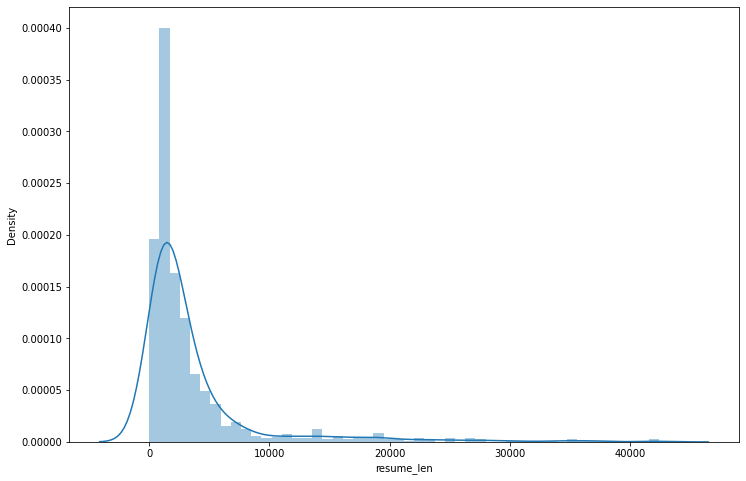

In [ ]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len)

In [ ]:
df.describe()

,Unnamed: 0,ID,resume_len
count,975.000000,975.000000,975.000000
mean,610.447179,611.447179,3562.997949
std,352.394066,352.394066,5452.826555
min,0.000000,1.000000,1.000000
25%,305.500000,306.500000,1028.000000
50%,615.000000,616.000000,1682.000000
75%,912.000000,913.000000,3449.500000
max,1218.000000,1219.000000,42408.000000


In [ ]:
max_resume_len = 200

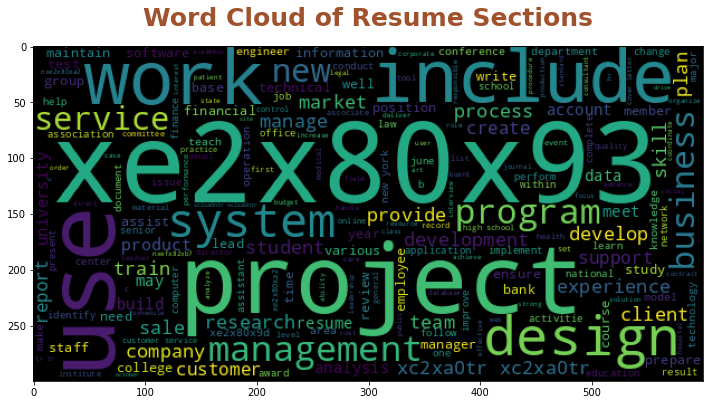

In [ ]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections',pad=20,fontsize=25,fontweight='bold',color='sienna')
plt.imshow(wc)

###Encoding the target labels i.e. all available jobs

In [ ]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Engineering': 0,
 'Education': 1,
 'Digital Media': 2,
 'BPO': 3,
 'Consultant': 4,
 'Arts': 5,
 'Finance': 6,
 'Accountant': 7,
 'Health & Fitness': 8,
 'Designing': 9,
 'Managment': 10,
 'Public Relations': 11,
 'Information Technology': 12,
 'Advocate': 13,
 'Apparel': 14,
 'Sales': 15,
 'Architects': 16,
 'Food & Beverages': 17,
 'Building & Construction': 18,
 'HR': 19,
 'Business Development': 20,
 'Automobile': 21,
 'Aviation': 22,
 'Banking': 23,
 'Agricultural': 24}

In [ ]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

In [ ]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = text_preprocess(df,'Resume')
preprocessed_df.head()

,Unnamed: 0,ID,Category,Resume,resume_len
0,978,979,0,bresume cover letter tip ms electrical academi...,20867
1,277,278,1,b education university new york ny na valid no...,1400
2,722,723,2,bhugh william university buffalo buffalo new y...,6531
3,602,603,3,bsample cv bpo jobsnnbipin bipinhaldar mission...,1339
4,679,680,4,bdeb nnover years experience candidate include...,6746


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


###Splitting the preprocessed dataset into training and test sets

In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

###Text Tokenization

In [ ]:
X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

###Defining the model architecture





In [ ]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.layers[2].trainable = True

###Visualizing the model architecture

In [ ]:
model.summary()

In [ ]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

In [ ]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=500,
             batch_size=32,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/500
22/22 [==============================] - ETA: 0s - loss: 3.9506 - balanced_accuracy: 0.0337
Epoch 1: val_balanced_accuracy improved from -inf to 0.00683, saving model to resume_parser.h5
22/22 [==============================] - 35s 1s/step - loss: 3.9506 - balanced_accuracy: 0.0337 - val_loss: 3.2251 - val_balanced_accuracy: 0.0068
Epoch 2/500
22/22 [==============================] - ETA: 0s - loss: 3.8494 - balanced_accuracy: 0.0323
Epoch 2: val_balanced_accuracy improved from 0.00683 to 0.02730, saving model to resume_parser.h5
22/22 [==============================] - 20s 916ms/step - loss: 3.8494 - balanced_accuracy: 0.0323 - val_loss: 3.2208 - val_balanced_accuracy: 0.0273
Epoch 3/500
22/22 [==============================] - ETA: 0s - loss: 3.7401 - balanced_accuracy: 0.0396
Epoch 3: val_balanced_accuracy improved from 0.02730 to 0.03413, saving model to resume_parser.h5
22/22 [==============================] - 21s 944ms/step - loss: 3.7401 - balanced_accuracy: 0.0396 -

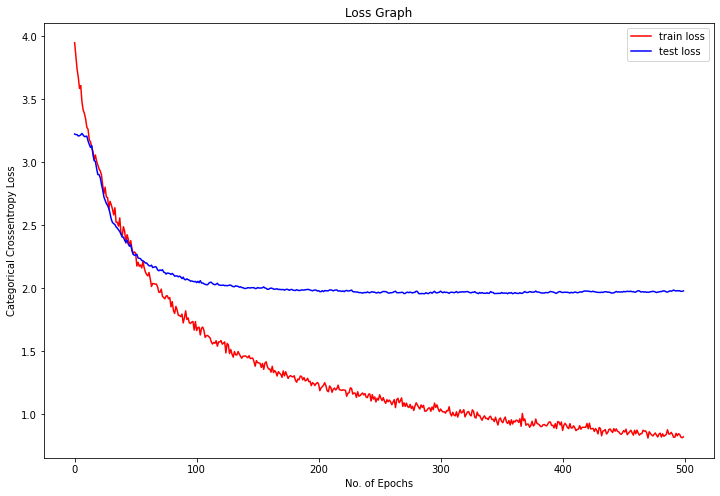

In [ ]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()

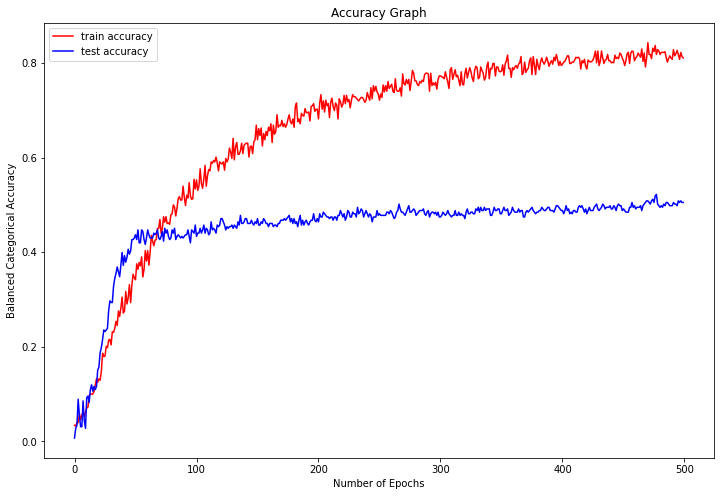

In [ ]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Categorical Accuracy')
plt.title('Accuracy Graph')
plt.legend()

###Model Evaluation

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category)
print("Test Sparse Categorical Crossentropy Loss:", loss)
print("Test Balanced Categorical Accuracy:", acc)

10/10 [==============================] - 2s 208ms/step - loss: 1.9794 - balanced_accuracy: 0.5051
Test Sparse Categorical Crossentropy Loss: 1.9793506860733032
Test Balanced Categorical Accuracy: 0.5051194429397583


In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

10/10 [==============================] - 4s 207ms/step


array([ 1, 24,  6,  8,  8,  7,  8,  0,  1,  7,  8,  0, 12, 12, 10,  2,  0,
        0,  6, 12, 10, 10, 10, 12,  0, 12, 12,  7,  1, 21,  8,  1, 11, 20,
       12, 15,  8,  3,  3,  5,  5, 19, 24,  7, 20,  0,  9,  0,  1,  1, 12,
        2,  0, 12,  2,  5,  0,  7,  0,  0,  6, 13, 12,  0,  0,  8,  6, 21,
       15,  1,  0, 10,  2,  2, 15,  1,  5,  0, 19,  1,  7,  5, 19, 19, 19,
       10,  0, 23,  3, 20,  0,  0,  8,  9, 23,  6, 13,  7,  9,  9, 23,  7,
        1, 12, 19,  0,  8,  2,  0, 10,  7,  8, 13, 13,  0, 19, 12, 19,  5,
       20,  1,  3,  0,  3,  0,  5,  6,  1, 15, 13, 23,  7, 20, 19,  5, 23,
        6,  7, 13, 24,  0, 20,  0,  0, 13, 12,  5,  2, 12,  7, 10, 19,  1,
        1, 13,  0, 12,  7,  9,  1,  2, 20,  9,  6, 15, 15,  0,  1, 12, 20,
       13,  0,  0,  1,  8, 12, 24,  9,  8,  0,  1, 15, 13, 24,  0, 10,  9,
       10, 14,  5, 24, 19, 15, 19,  9,  8,  0,  0,  0,  0, 24, 15, 12,  7,
       12, 12, 12,  7,  7,  0, 12, 13,  0,  1, 13, 24,  0, 24,  0, 20,  0,
        8, 12, 13, 13, 17

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(test_df.Category,test_predictions))
print("Classification Report:")
print(classification_report(test_df.Category,test_predictions))

Confusion Matrix:
[[23  3  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 5 20  0  0  0  0  1  0  1  0  1  0  4  0  0  1  0  0  0  0  0  0  0  0
   0]
 [ 1  2  2  0  0  2  0  1  0  0  1  0  3  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0]
 [ 1  0  0  1  0  0  0  0  0  0  2  0  3  1  0  1  0  0  0  1  0  0  0  0
   0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   2]
 [ 0  0  1  1  0  0  6  2  0  0  2  0  0  0  0  1  0  0  0  0  2  0  0  0
   0]
 [ 0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0 12  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0
   2]
 [ 0  0  1  0  0  1  0  0  0  6  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 3  0  5  0  0  0  0  4  0  0  3  0  1  1  0  2  0  0  0  1  1  0  0  1
   0]
 [ 1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 5  0  0  1  0  0  0

In [ ]:
import torch
import torchvision


In [ ]:
model_save_name = 'distilBert.pt'
path = F"/content/drive/MyDrive/FINAL PROJECT/CODE/Saved Models/T1" 
torch.save(model.state_dict(), path)

AttributeError: ignored